# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

In [3]:
from icecream import ic

In [4]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from dataset.cityscapes import Cityscapes
from dataset.cityscapes import CityscapesDataModule
from dataset.woodscape import WoodScapeDataset
from dataset.woodscape import WoodScapeDataModule
from dataset import WoodScapeSoilingDataset
from dataset import WoodScapeSoilingDataModule

In [6]:
from models import UnetSemSegModule
from dropblock import DropBlock2D

In [7]:
from utils.display_images import denormalize_img
from utils import show_dataset_image, show_dataset_mask
from utils import show_prediction_images, show_prediction_uncertainty_images

In [8]:
from ls_ood_detect.uncertainty_estimation import Hook
from ls_ood_detect.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_dl_h_z
from ls_ood_detect.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.detectors import KDEClassifier

# Compute Device

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Distribution Shift Detection:

Steps for using the package:

1. Load you Dataloader Pytorch-Lightning Module
2. Load your trained DNN PyTorch-Lightning Module
3. Add Hook to DNN Module for MC samples extraction
4. Get Monte-Carlo (MC) samples for In-Distribution (InD) samples dataloader, and Out-of-Distribution (OoD) samples dataloader
5. Get Entropy from InD and OoD MC samples
6. Build OoD Detection dataset (with InD and OoD samples)
7. Build OoD data-driven Detector (classifier)
8. Show OoD performance results

# Datasets

## Cityscapes

In [10]:
cs_dataset_path = './Data/DATASETS/CityScapes'
batch_size = 1
img_h = 128
img_w = 256

In [11]:
cs_dm_normal_unet = CityscapesDataModule(data_dir=cs_dataset_path,
                                         batch_size=batch_size,
                                         img_size=(img_h, img_w),
                                         target_type='semantic',
                                         num_workers=12,
                                         drop_last=True,
                                         default_transforms=False,
                                         default_img_mask_transforms=True)

In [12]:
cs_normal_train_loader = cs_dm_normal_unet.train_dataloader()
cs_normal_valid_loader = cs_dm_normal_unet.val_dataloader()
cs_normal_test_loader = cs_dm_normal_unet.test_dataloader()

In [13]:
ic(len(cs_normal_train_loader));
ic(len(cs_normal_valid_loader));
ic(len(cs_normal_test_loader));

ic| len(cs_normal_train_loader): 2975
ic| len(cs_normal_valid_loader): 500
ic| len(cs_normal_test_loader): 1525


In [14]:
cs_dm_anomal_unet = CityscapesDataModule(data_dir=cs_dataset_path,
                                         batch_size=batch_size,
                                         img_size=(img_h, img_w),
                                         target_type='semantic',
                                         num_workers=12,
                                         drop_last=True,
                                         default_transforms=True,
                                         default_img_mask_transforms=False)

In [15]:
cs_anomal_valid_loader = cs_dm_anomal_unet.anomaly_val_dataloader()
cs_anomal_test_loader = cs_dm_anomal_unet.anomaly_test_dataloader()

In [16]:
ic(len(cs_anomal_valid_loader));
ic(len(cs_normal_test_loader));

ic| len(cs_anomal_valid_loader)

: 500
ic| len(cs_normal_test_loader): 1525


## Woodscape

In [19]:
ws_dataset_path = './Data/DATASETS/WoodScape/'
batch_size = 1
img_h = 128
img_w = 256

In [20]:
ws_dm_normal_unet = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                        batch_size=batch_size,
                                        img_size=(img_h, img_w),
                                        num_workers=12,
                                        drop_last=True,
                                        default_transforms=True)
ws_dm_normal_unet.setup()

DATASET Shuffle Random SEED:  10


In [21]:
ws_train_loader = ws_dm_normal_unet.train_dataloader()
ws_valid_loader = ws_dm_normal_unet.val_dataloader()
ws_test_loader = ws_dm_normal_unet.test_dataloader()

In [22]:
ic(len(ws_train_loader));
ic(len(ws_valid_loader));
ic(len(ws_test_loader));

ic| len(ws_train_loader

): 5929
ic| len(ws_valid_loader): 1482
ic| len(ws_test_loader): 823


## Woodscape-Soiling

In [23]:
ws_soil_dataset_path = "./Data/DATASETS/WoodScape/soiling_dataset/"
batch_size = 1
img_h = 128
img_w = 256

In [24]:
ws_soil_dm = WoodScapeSoilingDataModule(dataset_dir=ws_soil_dataset_path,
                                        batch_size=1,
                                        img_size=(img_h, img_w),
                                        default_transforms=True,
                                        seed=9290)
ws_soil_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000
ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


DATASET Shuffle Random SEED:  9290


In [25]:
ws_soil_valid_loader = ws_soil_dm.val_dataloader()
ws_soil_test_loader = ws_soil_dm.test_dataloader()

In [26]:
ic(len(ws_soil_valid_loader));
ic(len(ws_soil_test_loader));

ic| len(ws_soil_valid_loader): 800


ic| len(ws_soil_test_loader): 1000


## Dataloaders Samples

In [27]:
dataiter_cs_valid = iter(cs_normal_valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


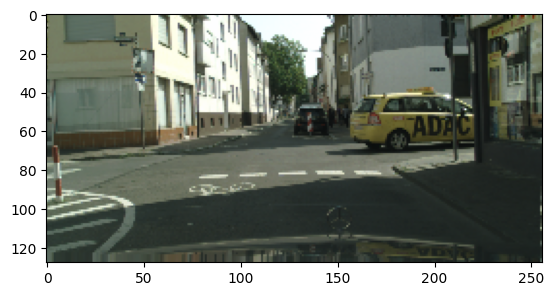

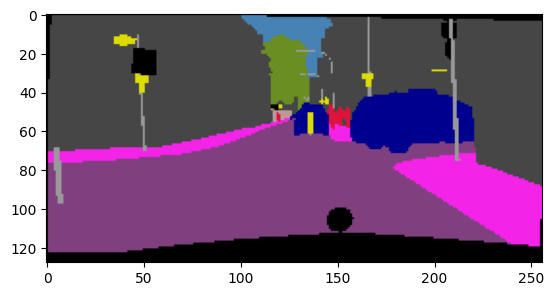

In [28]:
batch_ws_data, batch_ws_labels = dataiter_cs_valid.next()
plt.figure()
show_dataset_image(batch_ws_data[0], cs_dm_normal_unet.norm_mean, cs_dm_normal_unet.norm_std)
plt.figure()
show_dataset_mask(batch_ws_labels[0].squeeze(), cs_normal_valid_loader.dataset.decode_target)
plt.show()

In [29]:
dataiter_cs_anomal_valid = iter(cs_anomal_valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


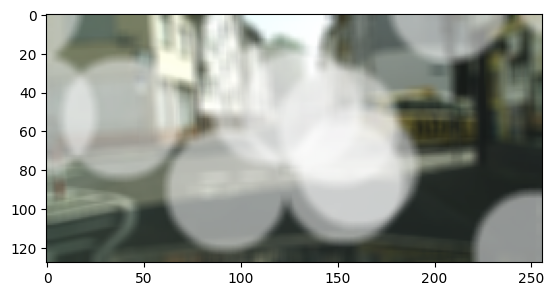

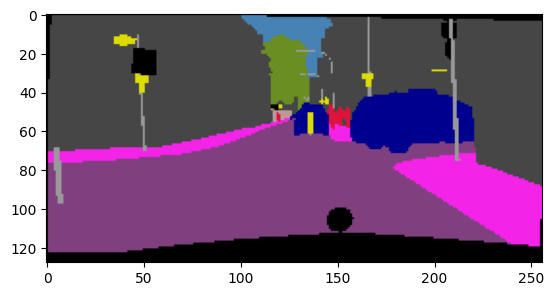

In [30]:
batch_cs_anomal_data, batch_cs_anomal_labels = dataiter_cs_anomal_valid.next()
plt.figure()
show_dataset_image(batch_cs_anomal_data[0], cs_dm_normal_unet.norm_mean, cs_dm_normal_unet.norm_std)
plt.figure()
show_dataset_mask(batch_cs_anomal_labels[0].squeeze(), cs_anomal_valid_loader.dataset.decode_target)
plt.show()

In [ ]:
dataiter_ws_soiling_valid = iter(ws_soil_valid_loader)

In [ ]:
batch_ws_soil_data, batch_ws_soil_labels = dataiter_ws_soiling_valid.next()
plt.figure()
show_dataset_image(batch_ws_soil_data[0], ws_dm_normal_unet.norm_mean, ws_dm_normal_unet.norm_std)
plt.show()

In [38]:
dataiter_ws_valid = iter(ws_valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


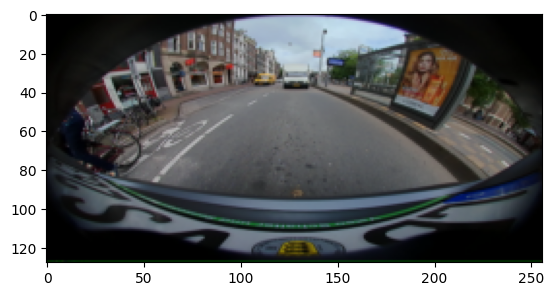

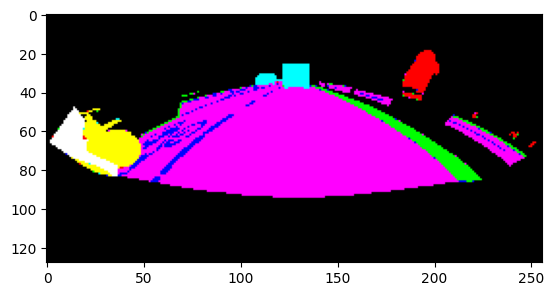

In [96]:
batch_ws_data, batch_ws_labels = dataiter_ws_valid.next()
plt.figure()
show_dataset_image(batch_ws_data[0], ws_dm_normal_unet.norm_mean, ws_dm_normal_unet.norm_std)
plt.figure()
show_dataset_mask(batch_ws_labels[0], ws_dm_normal_unet.woodscape_ds_train.decode_segmap)
plt.show()

# U-Net Cityscapes Model

In [54]:
cs_unet_path = "./Projects/Semantic_Segmentation_Unet/lightning_logs/version_157729/checkpoints/last.ckpt"
cs_unet_model = UnetSemSegModule.load_from_checkpoint(checkpoint_path=cs_unet_path)

In [55]:
ic(cs_unet_model.pred_loss_type);
ic(cs_unet_model.num_classes);

ic| cs_unet_model.pred_loss_type: 'cross_entropy'
ic| cs_unet_model.num_classes: 20


In [56]:
cs_unet_model.eval();

ic(cs_unet_model.unet_model.drop_block2d_layer);
ic(cs_unet_model.unet_model.drop_block2d_layer.block_size);
ic(cs_unet_model.unet_model.drop_block2d_layer.drop_prob);
ic(cs_unet_model.unet_model.drop_block2d_layer.training);
ic(cs_unet_model.unet_model.drop_block2d_layer._forward_hooks);

ic| cs_unet_model.unet_model.drop_block2d_layer: DropBlock2D()


ic| cs_unet_model.unet_model.drop_block2d_layer.block_size: 8
ic| cs_unet_model.unet_model.drop_block2d_layer.drop_prob: 0.4
ic| cs_unet_model.unet_model.drop_block2d_layer.training: False
ic| cs_unet_model.unet_model.drop_block2d_layer._forward_hooks: OrderedDict()


# Add Hook U-Net Cityscapes

In [57]:
cs_unet_hook_dropblock2d_layer = Hook(cs_unet_model.unet_model.drop_block2d_layer)

In [ ]:
ic(cs_unet_model.unet_model.drop_block2d_layer._forward_hooks);

# Get Monte Carlo Samples

In [59]:
# Monte Carlo Dropout - Enable Dropout @ Test Time!
def unet_apply_dropout(m):
    if type(m) == torch.nn.Dropout or type(m) == DropBlock2D:
        m.train()

In [60]:
mc_samples = 16

In [ ]:
cs_unet_model.unet_model.to(device);
cs_unet_model.unet_model.eval(); 
cs_unet_model.unet_model.apply(unet_apply_dropout); # enable dropout

ic(cs_unet_model.unet_model.drop_block2d_layer);
ic(cs_unet_model.unet_model.drop_block2d_layer.block_size);
ic(cs_unet_model.unet_model.drop_block2d_layer.drop_prob);
ic(cs_unet_model.unet_model.drop_block2d_layer.training);
ic(cs_unet_model.unet_model.drop_block2d_layer._forward_hooks);

In [ ]:
test = get_latent_represent_mcd_samples(cs_unet_model.unet_model,
                                        cs_normal_train_loader,
                                        mc_samples,
                                        cs_unet_hook_dropblock2d_layer,
                                        get_2d_rep_mean=True)

In [62]:
cs_unet_cs_normal_train_16mcds = get_latent_represent_mcd_samples(cs_unet_model.unet_model,
                                                                  cs_normal_train_loader,
                                                                  mc_samples,
                                                                  cs_unet_hook_dropblock2d_layer,
                                                                  get_2d_rep_mean=True)

In [63]:
cs_unet_cs_normal_valid_16mcds = get_latent_represent_mcd_samples(cs_unet_model.unet_model,
                                                                  cs_normal_valid_loader,
                                                                  mc_samples,
                                                                  cs_unet_hook_dropblock2d_layer,
                                                                  get_2d_rep_mean=True)

cs_unet_cs_normal_test_16mcds = get_latent_represent_mcd_samples(cs_unet_model.unet_model,
                                                                 cs_normal_test_loader,
                                                                 mc_samples,
                                                                 cs_unet_hook_dropblock2d_layer,
                                                                 get_2d_rep_mean=True)

In [64]:
cs_unet_cs_anomal_valid_16mcds = get_latent_represent_mcd_samples(cs_unet_model.unet_model,
                                                                  cs_anomal_valid_loader,
                                                                  mc_samples,
                                                                  cs_unet_hook_dropblock2d_layer,
                                                                  get_2d_rep_mean=True)

cs_unet_cs_anomal_test_16mcds = get_latent_represent_mcd_samples(cs_unet_model.unet_model,
                                                                 cs_anomal_test_loader,
                                                                 mc_samples,
                                                                 cs_unet_hook_dropblock2d_layer,
                                                                 get_2d_rep_mean=True)

In [65]:
cs_unet_ws_valid_16mcds = get_latent_represent_mcd_samples(cs_unet_model.unet_model,
                                                            ws_valid_loader,
                                                            mc_samples,
                                                            cs_unet_hook_dropblock2d_layer,
                                                            get_2d_rep_mean=True)

cs_unet_ws_test_16mcds = get_latent_represent_mcd_samples(cs_unet_model.unet_model,
                                                          ws_test_loader,
                                                          mc_samples,
                                                          cs_unet_hook_dropblock2d_layer,
                                                          get_2d_rep_mean=True)

In [66]:
cs_unet_ws_soil_valid_16mcds = get_latent_represent_mcd_samples(cs_unet_model.unet_model,
                                                                ws_soil_valid_loader,
                                                                mc_samples,
                                                                cs_unet_hook_dropblock2d_layer,
                                                                get_2d_rep_mean=True)

cs_unet_ws_soil_test_16mcds = get_latent_represent_mcd_samples(cs_unet_model.unet_model,
                                                               ws_soil_test_loader,
                                                               mc_samples,
                                                               cs_unet_hook_dropblock2d_layer,
                                                               get_2d_rep_mean=True)

In [68]:
ic(cs_unet_cs_normal_train_16mcds.shape);

ic| cs_unet_cs_normal_train_16mcds.shape: torch.Size(

[47600, 256])


In [69]:
torch.save(cs_unet_cs_normal_train_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/mc_samples/cs_unet_cs_normal_train_16mcds.pt')

In [70]:
torch.save(cs_unet_cs_normal_valid_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/mc_samples/cs_unet_cs_normal_valid_16mcds.pt')
torch.save(cs_unet_cs_normal_test_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/mc_samples/cs_unet_cs_normal_test_16mcds.pt')

In [71]:
torch.save(cs_unet_cs_anomal_valid_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/mc_samples/cs_unet_cs_anomal_valid_16mcds.pt')
torch.save(cs_unet_cs_anomal_test_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/mc_samples/cs_unet_cs_anomal_test_16mcds.pt')

In [72]:
torch.save(cs_unet_ws_valid_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/mc_samples/cs_unet_ws_valid_16mcds.pt')
torch.save(cs_unet_ws_test_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/mc_samples/cs_unet_ws_test_16mcds.pt')

In [73]:
torch.save(cs_unet_ws_soil_valid_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/mc_samples/cs_unet_ws_soil_valid_16mcds.pt')
torch.save(cs_unet_ws_soil_test_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/mc_samples/cs_unet_ws_soil_test_16mcds.pt')

# Get Entropy

In [74]:
_, cs_unet_h_z_cs_normal_train_samples_np = get_dl_h_z(cs_unet_cs_normal_train_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (2975, 1)
ic| dl_h_z_samples_np.shape: (2975, 256)


In [75]:
_, cs_unet_h_z_cs_normal_valid_samples_np = get_dl_h_z(cs_unet_cs_normal_valid_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (500, 1)
ic| dl_h_z_samples_np.shape: (500, 256)


In [76]:
_, cs_unet_h_z_cs_normal_test_samples_np = get_dl_h_z(cs_unet_cs_normal_test_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1525, 1)
ic| dl_h_z_samples_np.shape: (1525, 256)


In [77]:
_, cs_unet_h_z_cs_anomal_valid_samples_np = get_dl_h_z(cs_unet_cs_anomal_valid_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (500, 1)
ic| dl_h_z_samples_np.shape: (500, 256)


In [78]:
_, cs_unet_h_z_cs_anomal_test_samples_np = get_dl_h_z(cs_unet_cs_anomal_test_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1525, 1)
ic| dl_h_z_samples_np.shape: (1525, 256)


In [79]:
_, cs_unet_h_z_ws_valid_samples_np = get_dl_h_z(cs_unet_ws_valid_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1482, 1)
ic| dl_h_z_samples_np.shape: (1482, 256)


In [80]:
_, cs_unet_h_z_ws_test_samples_np = get_dl_h_z(cs_unet_ws_test_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (823, 1)
ic| dl_h_z_samples_np.shape: (823, 256)


In [81]:
_, cs_unet_h_z_ws_soil_valid_samples_np = get_dl_h_z(cs_unet_ws_soil_valid_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (800, 1)
ic| dl_h_z_samples_np.shape: (800, 256)


In [82]:
_, cs_unet_h_z_ws_soil_test_samples_np = get_dl_h_z(cs_unet_ws_soil_test_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1000, 1)
ic| dl_h_z_samples_np.shape: (1000, 256)


In [110]:
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_cs_normal_train_samples_np',
        cs_unet_h_z_cs_normal_train_samples_np)
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_cs_normal_valid_samples_np',
        cs_unet_h_z_cs_normal_valid_samples_np)
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_cs_normal_test_samples_np',
        cs_unet_h_z_cs_normal_test_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_cs_anomal_valid_samples_np',
        cs_unet_h_z_cs_anomal_valid_samples_np)
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_cs_anomal_test_samples_np',
        cs_unet_h_z_cs_anomal_test_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_ws_valid_samples_np',
        cs_unet_h_z_ws_valid_samples_np)
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_ws_test_samples_np',
        cs_unet_h_z_ws_test_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_ws_soil_valid_samples_np',
        cs_unet_h_z_ws_soil_valid_samples_np)
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_ws_soil_test_samples_np',
        cs_unet_h_z_ws_soil_test_samples_np)

# Load Entropy

In [46]:
cs_unet_h_z_cs_normal_train_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_cs_normal_train_samples_np.npy')
cs_unet_h_z_cs_normal_valid_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_cs_normal_valid_samples_np.npy')
cs_unet_h_z_cs_normal_test_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_cs_normal_test_samples_np.npy')

cs_unet_h_z_cs_anomal_valid_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_cs_anomal_valid_samples_np.npy')
cs_unet_h_z_cs_anomal_test_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_cs_anomal_test_samples_np.npy')

cs_unet_h_z_ws_valid_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_ws_valid_samples_np.npy')
cs_unet_h_z_ws_test_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_ws_test_samples_np.npy')

cs_unet_h_z_ws_soil_valid_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_ws_soil_valid_samples_np.npy')
cs_unet_h_z_ws_soil_test_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/cityscapes/entropy/cs_unet_h_z_ws_soil_test_samples_np.npy')